<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Useful-Scripts" data-toc-modified-id="Useful-Scripts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Useful Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Scaling" data-toc-modified-id="Scaling-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Random-Under-Sampling" data-toc-modified-id="Random-Under-Sampling-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Random Under Sampling</a></span></li><li><span><a href="#Train-test-split-with-stratify" data-toc-modified-id="Train-test-split-with-stratify-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Train test split with stratify</a></span></li><li><span><a href="#Check-for-nans-before-modelling" data-toc-modified-id="Check-for-nans-before-modelling-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Check for nans before modelling</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Deep-Learning-Imbalanced-Data" data-toc-modified-id="Deep-Learning-Imbalanced-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Deep Learning Imbalanced Data</a></span></li><li><span><a href="#Deep-Learning-Undersampled-Data" data-toc-modified-id="Deep-Learning-Undersampled-Data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Deep Learning Undersampled Data</a></span></li></ul></li><li><span><a href="#Keras-Deep-Learning-using-scikit-learn-API" data-toc-modified-id="Keras-Deep-Learning-using-scikit-learn-API-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Keras Deep Learning using scikit-learn API</a></span></li><li><span><a href="#Time-Taken" data-toc-modified-id="Time-Taken-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Time Taken</a></span></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Imports

In [1]:
import time
time_start_notebook = time.time()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

# random state
SEED=100
np.random.seed(SEED) # we need this in each cell

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 50)

import scipy
from scipy import stats

# scale and split
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

# deep learning
import tensorflow
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# model evaluation
import scikitplot
from scikitplot import metrics as skmetrics
import lrcurve
from lrcurve import KerasLearningCurve

# versions
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-09-29 

CPython 3.7.7
IPython 7.13.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

matplotlib 3.2.1
numpy      1.19.1
seaborn    0.10.1
sklearn    0.23.2
keras      2.4.3
tensorflow 2.3.0
json       2.0.9
scikitplot 0.3.7
scipy      1.4.1
pandas     1.1.1



# Useful Scripts

In [3]:
def show_methods(method, ncols=3):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_methods(list)
     """
    x = [i for i in dir(method) if i[0]!='_' ]
    x = [i for i in x 
         if i not in 'os np pd sys time psycopg2'.split() ]

    return pd.DataFrame(np.array_split(x,ncols)).T.fillna('')

In [4]:
def set_random_seed(seed):
    import os
    import random
    import numpy as np
    import tensorflow as tf
    
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [21]:
def model_evaluation(model_name, desc, ytest, ypreds,df_eval=None,
                     show=True,sort_col='Recall'):
    if df_eval is None:
        df_eval = pd.DataFrame({'Model': [],
                        'Description':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'AUC':[],
                    })

    # model evaluation
    average = 'binary'
    row_eval = [model_name,desc, 
                metrics.accuracy_score(ytest, ypreds),
                metrics.precision_score(ytest, ypreds, average=average),
                metrics.recall_score(ytest, ypreds, average=average),
                metrics.f1_score(ytest, ypreds, average=average),
                metrics.roc_auc_score(ytest, ypreds),
                ]

    df_eval.loc[len(df_eval)] = row_eval
    df_eval = df_eval.drop_duplicates()
    df_eval = df_eval.sort_values(sort_col)

    if show:
        display(df_eval.style.background_gradient(subset=[sort_col]))

    return df_eval


df_eval = None

# Load the data

In [6]:
df = pd.read_csv('../data/raw/creditcard.csv.zip',compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

0    284315
1       492
Name: Class, dtype: int64

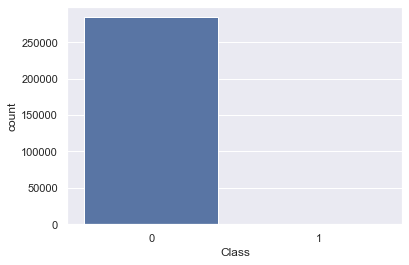

In [7]:
target = 'Class'
display(df[target].value_counts())
sns.countplot(df[target])

## Scaling

In [8]:
# RobustScaler is less prone to outliers.
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

## Random Under Sampling
- If classes are imbalanced, more frequent class causes overfitting.
- We can use undersampling of classes.
- Faster to train the model, since lower number of samples are remained.

Cons:
- Large number of rows may be dropped and risk of information loss.

In [9]:
# without removing outliers
n = df[target].value_counts().values[-1]

df_under = (df.groupby(target)
                .apply(lambda x: x.sample(n,random_state=SEED))
                .reset_index(drop=True)
               )

df_under[target].value_counts()

1    492
0    492
Name: Class, dtype: int64

## Train test split with stratify

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Without undersampling, (imbalanced data)
# Xtrain, and Xtest has all the features, later we can select our
# Xtrain and Xtest from df_train using some features.
target = 'Class'

Xtrain,Xtest,ytrain,ytest = train_test_split(df.drop(['Amount','Time',target],axis=1),
                                             df[target],
                                             test_size=0.2,
                                             stratify=df[target],
                                             random_state=SEED)

df.shape, Xtrain.shape, ytrain.shape

((284807, 33), (227845, 30), (227845,))

## Check for nans before modelling

In [19]:
np.isnan(Xtrain).any().any(), np.isnan(Xtest).any().any()

(False, False)

# Modelling

In [20]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam

## Deep Learning Imbalanced Data

In [26]:
def get_model():
    set_random_seed(SEED)
    nx, m = Xtrain.shape
    
    X_input = keras.layers.Input(shape = (m,))
    
    # Design the model
    X = keras.layers.BatchNormalization()(X_input)
    X = keras.layers.Dense(128, activation="tanh")(X)
    X = keras.layers.Dense(128, activation="tanh")(X)
    X = keras.layers.Dense(128, activation="relu")(X)
    X = keras.layers.Dropout(0.5)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(1, activation="sigmoid")(X)
    # for binary classification, make last dense layer 1 and use sigmoid.
    
    model = keras.models.Model(inputs= X_input, outputs = X)
    
    return model 

In [30]:
%%time

set_random_seed(SEED)
METRIC = 'Recall' 
# METRIC = 'accuracy'
class_weight = {0: 1., 1: 10}

callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
callback_lr = lrcurve.KerasLearningCurve()

model = get_model()

model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=[METRIC])

history = model.fit(Xtrain, ytrain,
            validation_split=0.2,
            batch_size=128,
            epochs=100,
            shuffle=True,
            class_weight=class_weight,
            callbacks=[callback_early,callback_lr],
            verbose=0)

CPU times: user 2min 52s, sys: 26 s, total: 3min 18s
Wall time: 1min 33s


In [71]:
# show_methods(history,3)

In [34]:
yprobs = model.predict(Xtest, batch_size=200, verbose=0).flatten()
yprobs[:5]

array([1.8456578e-04, 3.5392883e-11, 6.0794355e-07, 3.9904298e-09,
       1.9060991e-09], dtype=float32)

In [40]:
valid_probs = yprobs
yvalid = ytest

lst_score = []
arr_thr = np.linspace(0,1,1000)

for thr in arr_thr:
    valid_preds = (valid_probs>thr).astype(int)
    score = metrics.f1_score(yvalid, valid_preds)
    lst_score.append(score)

arr_score = np.array(lst_score)
best_idx = np.argmax(arr_score)
best_thr = arr_thr[best_idx]
print(f'Best threshold: {best_thr}')

valid_preds = (valid_probs > best_thr).astype(int)
score = metrics.f1_score(yvalid, valid_preds)
print(f'Best threshold score : {score}')

Best threshold: 0.6196196196196196
Best threshold score : 0.7731958762886597


[[56837    27]
 [   21    77]]
Keras Imbalaned Data Results
-------------------------
Total Frauds:  98
Incorrect Frauds:  21
Incorrect Percent:  21.43 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.79      0.76        98

    accuracy                           1.00     56962
   macro avg       0.87      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962



,Model,Description,Accuracy,Precision,Recall,F1,AUC
1,keras,imbalanced,0.999210,0.773196,0.765306,0.769231,0.882460
2,keras,"imbalanced, threshold optimized",0.999210,0.773196,0.765306,0.769231,0.882460
0,keras,imbalanced,0.999157,0.740385,0.785714,0.762376,0.892620
3,keras,"imbalanced, threshold 0.5",0.999157,0.740385,0.785714,0.762376,0.892620


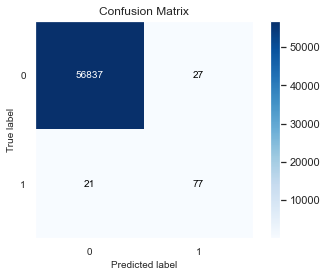

In [55]:
THRESHOLD = 0.5
ypreds = np.array([0 if i <= THRESHOLD else 1 for i in yprobs])

# confusion matrix
cm = skmetrics.confusion_matrix(ytest,ypreds)
vals = cm.ravel()
print(cm)
print('Keras Imbalaned Data Results')
print('-'*25)
print('Total Frauds: ', vals[2] + vals[3])
print('Incorrect Frauds: ', vals[2])
print('Incorrect Percent: ', round(vals[2]*100/(vals[2]+vals[3]),2),'%')

# clf report
report = metrics.classification_report(ytest, ypreds)
print(report)

# eval
df_eval = model_evaluation('keras', 'imbalanced, threshold 0.5', ytest, ypreds,df_eval=df_eval)

# plot
skmetrics.plot_confusion_matrix(ytest,ypreds.ravel())

In [56]:
show_methods(skmetrics)

,0,1,2
0,LabelEncoder,itertools,plot_silhouette
1,absolute_import,label_binarize,plt
2,auc,plot_calibration_curve,precision_recall_curve
3,average_precision_score,plot_confusion_matrix,print_function
4,binary_ks_curve,plot_cumulative_gain,roc_curve
5,calibration_curve,plot_ks_statistic,silhouette_samples
6,confusion_matrix,plot_lift_curve,silhouette_score
7,cumulative_gain_curve,plot_precision_recall,unicode_literals
8,deprecated,plot_precision_recall_curve,unique_labels
9,division,plot_roc,validate_labels


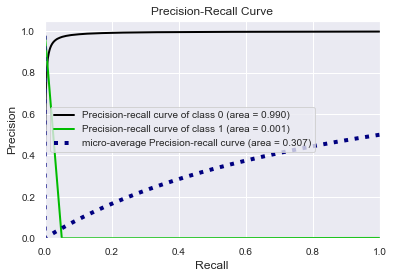

In [61]:
skmetrics.plot_precision_recall(ytest,np.c_[yprobs,1-yprobs])

# Time Taken

In [89]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 33 min 10 secs
